In [1]:
#load libraries
from aicsimageio import AICSImage #handles czi data
import numpy as np
from napari.viewer import Viewer
import skimage.filters as skif
import matplotlib.pyplot as plt
import skimage.morphology as skimo
import scipy.ndimage as nd
import skimage.measure as skime
import pandas as pd
%matplotlib inline

#create instance of napari viewer
viewer = Viewer()

In [2]:
def morph(image, morph_disk_size):
    img = nd.binary_dilation(image,structure=skimo.disk(morph_disk_size), iterations = 3)
    img = nd.binary_erosion(img,structure=skimo.disk(morph_disk_size), iterations = 3)
    img = skimo.binary_dilation(img,footprint=skimo.disk(morph_disk_size))
    return img

In [3]:
#read in one image stack
img_movie = AICSImage("C:/Users/mrfel/Desktop/Python_random/Movie2.czi")
print(img_movie.dims)
print(img_movie.shape)
#reduce dimensionality of the image to only T, Y and X
img_movie = img_movie.get_image_data("TYX")
# img_movie = img_movie.data
#create the mean projection of the movie
img_mean = np.mean(img_movie.data, axis = 0)
#subtract mean projection of the movie
movie_mean = img_movie.data - img_mean
#create min projection of the previous processed movie
img_mean_min = np.min(movie_mean, axis = 0)
#calculate the threshold of the min projeciton with otsu
threshold = skif.threshold_otsu(img_mean_min)
print(threshold)
#create binary movie with threshold
movie_binary = movie_mean < (threshold)
morph_disk_size = 1
binary_proc = np.zeros(movie_binary.shape, dtype=bool)
for i in range(0,movie_binary.shape[0]):
    binary_proc[i,:,:] = morph(movie_binary[i,:,:],morph_disk_size)
    print(str(i)+" iteration step done")
label_img = np.zeros(binary_proc.shape)
for i in range(0,binary_proc.shape[0]):
    label_img[i,:,:] = skimo.label(binary_proc[i,:,:], connectivity=1)
label_img = label_img.astype("int64")

<Dimensions [T: 100, C: 1, Z: 1, Y: 2048, X: 2048]>
(100, 1, 1, 2048, 2048)
-62.715273437499945
0 iteration step done
1 iteration step done
2 iteration step done
3 iteration step done
4 iteration step done
5 iteration step done
6 iteration step done
7 iteration step done
8 iteration step done
9 iteration step done
10 iteration step done
11 iteration step done
12 iteration step done
13 iteration step done
14 iteration step done
15 iteration step done
16 iteration step done
17 iteration step done
18 iteration step done
19 iteration step done
20 iteration step done
21 iteration step done
22 iteration step done
23 iteration step done
24 iteration step done
25 iteration step done
26 iteration step done
27 iteration step done
28 iteration step done
29 iteration step done
30 iteration step done
31 iteration step done
32 iteration step done
33 iteration step done
34 iteration step done
35 iteration step done
36 iteration step done
37 iteration step done
38 iteration step done
39 iteration step

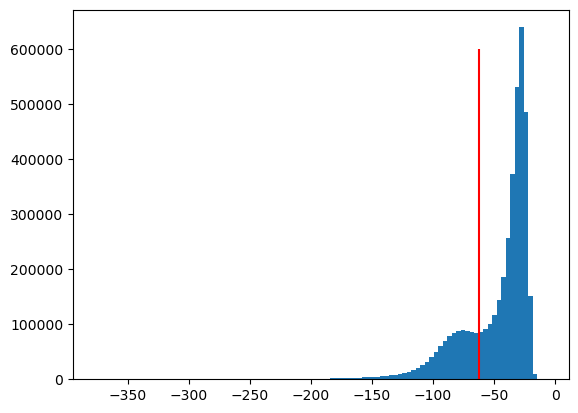

In [4]:
plt.hist(img_mean_min.ravel(), bins = 100)
plt.vlines(x=threshold, ymin=0, ymax=600000, colors = 'red')
plt.show()

In [5]:
#add image and label
viewer.add_image(img_movie, name = 'original movie')
viewer.add_image(binary_proc, name = 'binary')
viewer.add_labels(label_img, name = 'sporo label')

<Labels layer 'sporo label' at 0x23590896bc0>

In [6]:
#try different area , maybe 50 or just check the histogram again
binary_proc2 = np.zeros(binary_proc.shape, dtype=bool)
for i in range(0,binary_proc.shape[0]):
    binary_proc2[i,:,:] = skimo.area_opening(binary_proc[i,:,:], 10, connectivity = 1)
    print(str(i)+" iteration step done")

0 iteration step done
1 iteration step done
2 iteration step done
3 iteration step done
4 iteration step done
5 iteration step done
6 iteration step done
7 iteration step done
8 iteration step done
9 iteration step done
10 iteration step done
11 iteration step done
12 iteration step done
13 iteration step done
14 iteration step done
15 iteration step done
16 iteration step done
17 iteration step done
18 iteration step done
19 iteration step done
20 iteration step done
21 iteration step done
22 iteration step done
23 iteration step done
24 iteration step done
25 iteration step done
26 iteration step done
27 iteration step done
28 iteration step done
29 iteration step done
30 iteration step done
31 iteration step done
32 iteration step done
33 iteration step done
34 iteration step done
35 iteration step done
36 iteration step done
37 iteration step done
38 iteration step done
39 iteration step done
40 iteration step done
41 iteration step done
42 iteration step done
43 iteration step don

In [7]:
label_img2 = np.zeros(binary_proc2.shape)
for i in range(0,binary_proc2.shape[0]):
    label_img2[i,:,:] = skimo.label(binary_proc2[i,:,:], connectivity=1)
label_img2 = label_img2.astype("int64")

In [8]:
viewer.add_image(binary_proc2, name = 'binary2')
viewer.add_labels(label_img2, name = 'sporo label2')

<Labels layer 'sporo label2' at 0x23598a4be20>

In [ ]:
for t in range(0,label_img.shape[0]):
    region_props = skime.regionprops_table(label_img[t,:,:], 
                                            properties = ['label','axis_major_length','axis_minor_length'])
    print("Region Props done!")
    region_props = pd.DataFrame(region_props)
    region_props['AR'] = (region_props['axis_major_length']/region_props['axis_minor_length'])
    idx = np.asarray(region_props.loc[region_props['AR'] < 2.5,['label']])
    print("Indexing done!")
    for y in range(0,label_img.shape[1]):
        if np.max(label_img[t,y,:]) > 0:
            for e in np.unique(label_img[t,y,:]):
                if e in idx:
                    for x in range(0,label_img.shape[2]):
                        if label_img[t,y,x] in idx:
                            label_img[t,y,x] = 0
    print(t)

In [ ]:
a = np.arange(100)
np.unique(label_img[0,2,:])
for e in np.unique(label_img[0,80,:]):
    if e in idx:
        print(e)

In [ ]:
props = skime.regionprops_table(label_img[80,:,:], properties=['label','area','axis_major_length','axis_minor_length'])
df = pd.DataFrame(props)
df['AR'] = (df['axis_major_length']/df['axis_minor_length'])
df

In [ ]:
df[['area','solidity','eccentricity','AR']].hist(bins = 100)

In [ ]:
df2 = df.loc[(df['AR'] > 2.5),'area']
df2.hist(bins = 100)

In [ ]:
df2.min()

In [ ]:
l1 = label_img[0,:,:]

In [ ]:
for i in range(0,l1.shape[0]):
    if np.max(l1[i,:]) > 0:
        for j in range(0,l1.shape[1]):
            if l1[i,j] in idx:
                print(str(l1[i,j])+" changed to 0")
                l1[i,j] = 0

In [ ]:
# viewer.add_labels(label_img[0,:,:], name = "original label")
viewer.add_labels(l1, name = "filtered label")

In [ ]:
prop = skime.regionprops_table(label_img1, properties=['label','area','eccentricity'])

In [ ]:
pd.DataFrame(prop)

In [ ]:
morph_disk_size = 1
dilated1 = skim.binary_dilation(movie_binary[0,:,:],footprint=skim.disk(morph_disk_size))
opend = skim.binary_opening(movie_binary[0,:,:],footprint=skim.disk(morph_disk_size))
opend_dilated = skim.binary_dilation(opend,footprint=skim.disk(morph_disk_size))
closed = skim.binary_closing(movie_binary[0,:,:],footprint=skim.disk(morph_disk_size))
closed_dilated = skim.binary_dilation(closed,footprint=skim.disk(morph_disk_size))

In [ ]:
morph_disk_size = 1
a = nd.binary_dilation(movie_binary[0,:,:],structure=skim.disk(morph_disk_size), iterations = 3)
a = nd.binary_erosion(a,structure=skim.disk(morph_disk_size), iterations = 3)
a = skim.binary_dilation(a,footprint=skim.disk(morph_disk_size))
viewer.add_image(a, opacity = 0.7, colormap = 'magenta')

In [ ]:
movie_binary.shape[0]

In [ ]:
viewer.add_image(movie_binary[0,:,:], opacity = 1, colormap = 'cyan', name = 'sporo mask')
viewer.add_image(dilated1, opacity = 0.7, colormap = 'magenta', name = 'sporo mask 1x dilated')
viewer.add_image(opend, opacity = 0.7, colormap = 'magenta', name = 'sporo mask 1x opened')
viewer.add_image(opend_dilated, opacity = 0.7, colormap = 'magenta', name = 'sporo mask 1x opend+dilated')
viewer.add_image(closed, opacity = 0.7, colormap = 'magenta', name = 'sporo mask 1x closed')
viewer.add_image(closed_dilated, opacity = 0.7, colormap = 'magenta', name = 'sporo mask 1x closed+dilated')

In [ ]:
#read in one image stack
img_movie = AICSImage("C:/Users/mrfel/Desktop/Python_random/Movie1.czi")
print(img_movie.dims)
print(img_movie.shape)

In [ ]:
#create instance of napari viewer
viewer = Viewer()

In [ ]:
#add movie to napari viewer
viewer.add_image(img_movie.data, colormap="gray", name="OriginalMovie")

In [ ]:
#create average, median, sum and max projection of movie
img_median = np.median(img_movie.data, axis = 0)
img_mean = np.mean(img_movie.data, axis = 0)
img_sum = np.sum(img_movie.data, axis = 0)
img_max = np.max(img_movie.data, axis = 0)

In [ ]:
#add projections to napari
viewer.add_image(img_median,colormap="gray",name="Median_Projection")
viewer.add_image(img_mean,colormap="gray",name="Mean_Projection")
viewer.add_image(img_sum,colormap="gray",name="Sum_Projection")
viewer.add_image(img_max,colormap="gray",name="Max_Projection")

In [ ]:
#subtract projections from original image
movie_median = img_movie.data - img_median
movie_mean = img_movie.data - img_mean
movie_sum = img_movie.data - img_sum
movie_max = img_movie.data - img_max

In [ ]:
#add new images to napari
viewer.add_image(movie_median,colormap="gray",name="MedianMovie")
viewer.add_image(movie_mean,colormap="gray",name="MeanMovie")
viewer.add_image(movie_sum,colormap="gray",name="SumMovie")
viewer.add_image(movie_max,colormap="gray",name="MaxMovie")

To sum up: subtracting median and mean projection from the original movie shows good removing of background from the original movie and highlights the sporozoits.
Subtracting max projection and sum projection from the original movie produces either a completely dark or brigt image.

In [ ]:
import skimage.filters as skif

In [ ]:
skif.threshold_otsu(movie_median)

In [ ]:
skif.threshold_otsu(movie_median[0,0,0,:,:])

In [ ]:
plt.hist(movie_median[0,0,0,:,:].ravel(), bins = 100)
plt.show()

In [ ]:
print(skif.threshold_otsu(movie_median[0,0,0,:,:]))
print(skif.threshold_multiotsu(movie_median[0,0,0,:,:]))
img_mean_min = np.min(movie_mean, axis = 0)
print(skif.threshold_otsu(img_mean_min))
print(skif.threshold_multiotsu(img_mean_min))
viewer.add_image(img_mean_min)

In [ ]:
#create average, median, sum and max projection of movie
img = img_mean_min < -58
viewer.add_image(img)

In [ ]:
movie = movie_mean < -58
viewer.add_image(movie)

In [ ]:
import skimage.morphology as skim

In [ ]:
disk_size = 10
disk = skim.disk(disk_size)
mov_closed = skim.binary_closing(movie)
viewer.add_image(mov_closed)

In [ ]:
label = skim.label(mov_closed)
viewer.add_labels(label)